__Table Of Content__

1. [Get an overview of the data](#1)

1. [Explore the Data (EDA)](#2)

    2.1 [Cardinality and Consistency](##2)
    
    2.2 [View null values](##2)
    
    2.3 [Correlation and Outliers](##2)
    
1. [Feature Engineering and Pipeline](#3)

    3.1 [Engineering of remaining features](##3)
    
    3.2 [Pipeline construction](##3)
    
1. [Model construction and evaluation](#4)

    4.1 [XGBRegressor vs. SVR](##4)
    
    4.2 [Dense Neural Network](##4)
    
    4.3 [Finetuning the best XGB model](##4)
    
1. [Packing together and make submission](#5)

# Get an overview of the data

In [1]:
# import data and modules
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import re
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
# read the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

We have two sets of data: one for training (called __train_df__) and another for testing (referred to as __test_df__). I believe it would be a good idea to combine these sets because of how the data is spread out. Imagine a situation where a certain category of information is present in the testing data but missing in the training data. This could have important implications when we later work on improving the features of the data.

In [3]:
# shapes of train vs test
print(f"Shape of train set: {train_df.shape}")
print(f"Shape of test set: {test_df.shape}")

Shape of train set: (1460, 81)
Shape of test set: (1459, 80)


In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


We can see, that in the test set a column is missing. Let's view it.

In [6]:
train_set = set(train_df.columns.tolist())
test_set = set(test_df.columns.tolist())

missing = list(sorted(train_set - test_set))
missing

['SalePrice']

The test set doesn't have the crucial __Target__ column that our machine learning system relies on. If we decide to put together the train and test sets just to explore the data, we'll need to later split them back into separate parts. This separation should happen exactly where we initially joined the sets together.

In [7]:
# join train and test set only for exploration
dataset = pd.concat([train_df, test_df], axis=0)
dataset.shape

(2919, 81)

In [8]:
# check if the rows joined correcty
assert dataset.shape[0] == train_df.shape[0] + test_df.shape[0]

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [10]:
numerical_cols = [col for col in dataset.columns if dataset[col].dtype != 'object']
categorical_cols = [col for col in dataset.columns if dataset[col].dtype == 'object']

# Explore the Data (EDA)

## Cardinality and Consistency

We should examine the cardinality of the combined dataset to ensure that no categorical values are missing, as indicated in the data description. This step holds significance for a preprocessing pipeline, especially when categorical values are being transformed into numerical representations.

In [11]:
# read the description file
description = None
with open('data_description.txt', 'r') as dd:
    description = dd.readlines()

# parse the data using regex and split
categories = {}
last_match = None
for line in description:
    match = re.search(r'^[\d\w]+:', line)
    if match and match.group()[:-1] not in categories.keys():
        categories[match.group()[:-1]] = []
        last_match = match.group()[:-1]
    else:
        try:
            splitted_line = line.split('\t')
            if splitted_line[0].strip():
                categories[last_match].append(splitted_line[0].strip())
        except:
            continue

In [12]:
# check if the cardinality of the column are the same of the description file
for col in dataset.columns:
    if dataset[col].dtype=='object':
        col_values = set([str(d) for d in dataset[col].unique() if str(d) != 'nan']) # filter nan values out
        desc_values = set([str(c) for c in categories[col] if c != 'NA'])

        added = list(sorted(col_values - desc_values))
        missing = list(sorted(desc_values - col_values))
        if added:
            print(f"{col}: added to the description: {added}")
        if missing:
            print(f"{col}: missing from the description: {missing}")

MSZoning: added to the description: ['C (all)']
MSZoning: missing from the description: ['A', 'C', 'I', 'RP']
Utilities: missing from the description: ['ELO', 'NoSewr']
Neighborhood: added to the description: ['NAmes']
Neighborhood: missing from the description: ['Names']
Condition2: missing from the description: ['RRNe']
BldgType: added to the description: ['2fmCon', 'Duplex', 'Twnhs']
BldgType: missing from the description: ['2FmCon', 'Duplx', 'TwnhsI']
Exterior1st: missing from the description: ['Other', 'PreCast']
Exterior2nd: added to the description: ['Brk Cmn', 'CmentBd', 'Wd Shng']
Exterior2nd: missing from the description: ['BrkComm', 'CemntBd', 'PreCast', 'WdShing']
MasVnrType: missing from the description: ['CBlock']
ExterQual: missing from the description: ['Po']
BsmtQual: missing from the description: ['Po']
BsmtCond: missing from the description: ['Ex']
KitchenQual: missing from the description: ['Po']
Functional: missing from the description: ['Sal']
PoolQC: missing from

Indeed, there are several columns in which the data diverges from what is stated in the description file. It appears that there are a few typographical errors present. Therefore, we should rectify these inconsistencies based on the premise that the information provided in the description file is accurate and reliable.

In [13]:
# correct column MSZoning typos
dataset.MSZoning = dataset.MSZoning.str.replace('C (all)', 'C', regex=False)

# correct column Neighborhood typos
dataset.Neighborhood = dataset.Neighborhood.str.replace('NAmes', 'Names')

# correct column BldgType typos
dataset.BldgType = dataset.BldgType.str.replace('2fmCon', '2FmCon')
dataset.BldgType = dataset.BldgType.str.replace('Duplex', 'Duplx')
dataset.BldgType = dataset.BldgType.str.replace('Twnhs', 'TwnhsI')
dataset.BldgType = dataset.BldgType.str.replace('TwnhsIE', 'TwnhsE')

# correct column Exterior2nd typos
dataset.Exterior2nd = dataset.Exterior2nd.str.replace('Brk Cmn', 'BrkComm')
dataset.Exterior2nd = dataset.Exterior2nd.str.replace('CmentBd', 'CemntBd')
dataset.Exterior2nd = dataset.Exterior2nd.str.replace('Wd Shng', 'WdShing')

Taking another look at the dataset to find out if any data is still missing even after fixing the typos based on the description file.

In [14]:
# check  again after correction which data is missing from the description file
for col in dataset.columns:
    if dataset[col].dtype=='object':
        col_values = set([str(d) for d in dataset[col].unique() if str(d) != 'nan']) # filter nan values out
        desc_values = set([str(c) for c in categories[col] if c != 'NA']) 
        # implicitly checked if column exists in description -> categories[col] -> no KeyError

        added = list(sorted(col_values - desc_values))
        missing = list(sorted(desc_values - col_values))
        if added:
            print(f"{col}: added to the description: {added}")
        if missing:
            print(f"{col}: missing from the description: {missing}")

MSZoning: missing from the description: ['A', 'I', 'RP']
Utilities: missing from the description: ['ELO', 'NoSewr']
Condition2: missing from the description: ['RRNe']
Exterior1st: missing from the description: ['Other', 'PreCast']
Exterior2nd: missing from the description: ['PreCast']
MasVnrType: missing from the description: ['CBlock']
ExterQual: missing from the description: ['Po']
BsmtQual: missing from the description: ['Po']
BsmtCond: missing from the description: ['Ex']
KitchenQual: missing from the description: ['Po']
Functional: missing from the description: ['Sal']
PoolQC: missing from the description: ['TA']
MiscFeature: missing from the description: ['Elev']
SaleType: missing from the description: ['VWD']


__We have to take that into account for the data preprocessing steps.__

## View null values

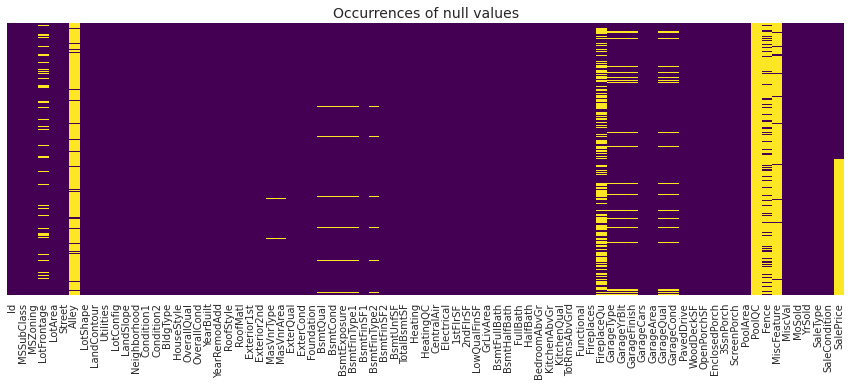

In [15]:
plt.figure(figsize=(15, 5))
sns.heatmap(data=dataset.isnull(), cmap='viridis', yticklabels=False, xticklabels=True, cbar=False)
plt.title('Occurrences of null values', fontsize=14)
plt.show()

In this case, we can observe that several columns have missing values (often represented as Null or NaN). The columns named __Alley__, __PoolQC__, __Fence__, and __MiscFeature__ stand out because they have a high number of missing values, which makes it difficult to adequately fill or replace those missing entries.

## Correlation and Outliers

To examine the relationship between SalePrice and all the features, we create a visualization known as a __correlation heatmap__. __Pearson's Correlation__ is quite resilient to the impact of __outliers__. Hence, we will contrast the correlations obtained through both __Pearson's__ and __Spearman's__ correlation methods using the original data. In the subsequent steps, we will exclusively consider the __train set__ since it contains the SalePrice information.

In [16]:
# create a dictionary for conversion of categorical to numerical values from description file
# using the categories dict from 2.1
cat2num = {}
for key, value in categories.items():
    item2num = {}
    for i, item in enumerate(value):
        item2num[item] = i
    cat2num[key] = item2num

In [17]:
# function to convert a DataFrame's categorical to numerical columns by description file values
def convert_cat2num(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            target_dict = cat2num[col]
            try:
                df[col] = df[col].apply(lambda x: target_dict[x] if not pd.isna(x) else x).astype('int64')
            except:
                df[col] = df[col].apply(lambda x: target_dict[x] if not pd.isna(x) else x).astype('float')
                df[col].fillna(df[col].value_counts().index[0], inplace=True)

In [18]:
# create a new dataframe for correlation analysis
plot_df = dataset.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1).copy()
# apply cat to num
plot_df = plot_df[plot_df.SalePrice.notnull()] 
convert_cat2num(plot_df)

We should verify whether the data includes any columns that are predominantly populated by a single value.

In [19]:
desc_df = plot_df.describe()
desc_df.loc[:,desc_df.loc['max'] - desc_df.loc['min'] == 0]

""
count
mean
std
min
25%
50%
75%
max


Because these two columns are mostly filled with the value __1__, they don't provide much useful information. We can go ahead and __remove__ them.

In [20]:
plot_df.drop(['Street', 'CentralAir'], axis=1, inplace=True)

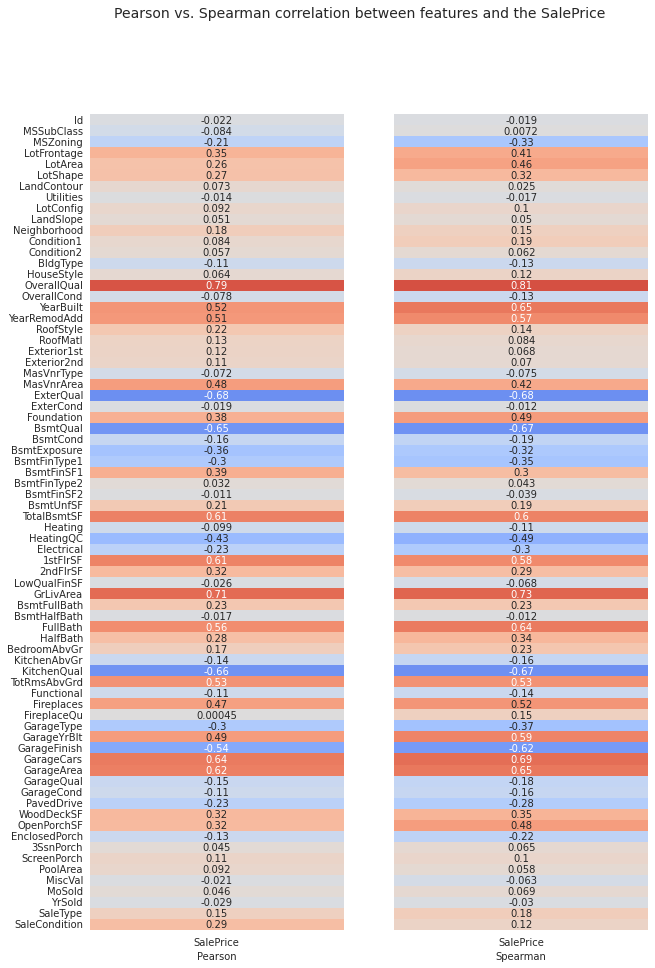

In [21]:
# plotting the corrlelations
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 15), sharey=True)
sns.heatmap(data=plot_df.corr(method='pearson').loc[:,['SalePrice']].iloc[:-1],
            vmin=-1.0, vmax=1.0, cmap='coolwarm', annot=True, cbar=False, ax=ax1)
sns.heatmap(data=plot_df.corr(method='spearman').loc[:,['SalePrice']].iloc[:-1], 
            vmin=-1.0, vmax=1.0, cmap='coolwarm', annot=True, cbar=False, ax=ax2)
ax1.set_xlabel('Pearson')
ax2.set_xlabel('Spearman')
fig.suptitle('Pearson vs. Spearman correlation between features and the SalePrice', fontsize=14)
plt.show()

__Spearman's__ correlation coefficient is less affected by outliers, which suggests that most features exhibit slightly stronger correlations with SalePrice using this measure. To proceed, we should establish a threshold for feature extraction.

In [22]:
threshold = 0.3

# pearson
pearson_df = plot_df.corr(method='pearson')
pearson_df[(pearson_df.abs() > threshold)].loc[:,['SalePrice']].iloc[:-1].dropna().shape

(26, 1)

In [23]:
# spearman
spearman_df = plot_df.corr(method='spearman')
spearman_df[(spearman_df.abs() > threshold)].loc[:,['SalePrice']].iloc[:-1].dropna().shape

(30, 1)

Here, we observe that utilizing __Spearman's__ correlation would result in extracting __5__ additional features compared to __Pearson's__ correlation. To validate, let's examine whether the values are identical except for the differing feature.

In [24]:
# which values are different from each other
pearson_features = set(pearson_df[(pearson_df.abs() > threshold)].loc[:,['SalePrice']].iloc[:-1]\
.dropna().index.tolist())

spearman_features = set(spearman_df[(spearman_df.abs() > threshold)].loc[:,['SalePrice']]\
.iloc[:-1].dropna().index.tolist())

added = list(sorted(pearson_features - spearman_features))
missing = list(sorted(spearman_features - pearson_features))

print(f"pearson not in spearman: {added}")
print(f"spearman not in pearson: {missing}")

pearson not in spearman: ['2ndFlrSF']
spearman not in pearson: ['BsmtFinType1', 'HalfBath', 'LotArea', 'LotShape', 'MSZoning']


Using Spearman correlation, we would choose __6__ different features compared to the selection based on Pearson correlation. With Pearson correlation, there's just __1__ feature that would be different from the Spearman selection.

Regarding the __categorical-to-numerical__ transformation mentioned earlier, we've already taken care of the missing values in categorical columns by filling them the __most frequent value__. Let's review this again to make sure it's clear.

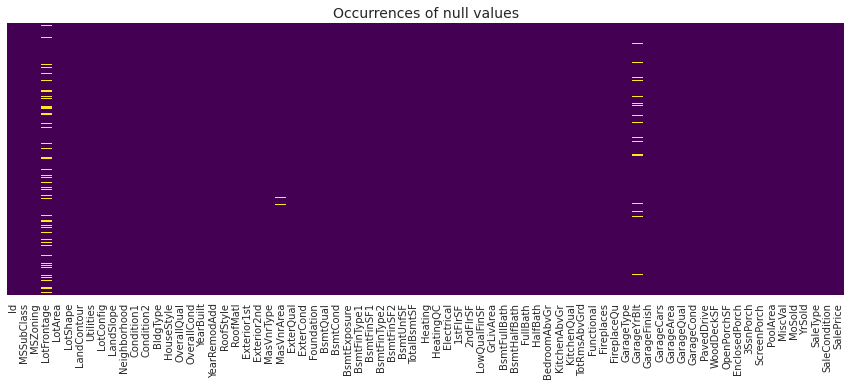

In [25]:
plt.figure(figsize=(15, 5))
sns.heatmap(data=plot_df.isnull(), cmap='viridis', yticklabels=False, xticklabels=True, cbar=False)
plt.title('Occurrences of null values', fontsize=14)
plt.show()

In [26]:
plot_df['MasVnrArea'].fillna(plot_df.MasVnrArea.value_counts().index[0], inplace=True)

Referring to our NaN Value Heatmap from earlier, we notice that two columns, namely __LotFrontage__ and __GarageYrBlt__, still require feature engineering. Let's investigate whether either of these features is included in the selection determined by Spearman correlation, as it is a more robust measure when it comes to handling outliers.

In [27]:
'LotFrontage' in spearman_features

True

In [28]:
'GarageYrBlt' in spearman_features

True

Both __LotFrontage__ and __GarageYrBlt__ are part of the features selected by __Spearman__ correlation, indicating that they need attention. Let's start with addressing the __LotFrontage__ feature. To handle its null values, we can search for a correlated partner among the other features. If the correlation is sufficiently strong (greater than 0.5, for instance), we can utilize a function to estimate the __LotFrontage__ values. We'll visualize this process similarly to how we did before, employing a __correlation heatmap__.

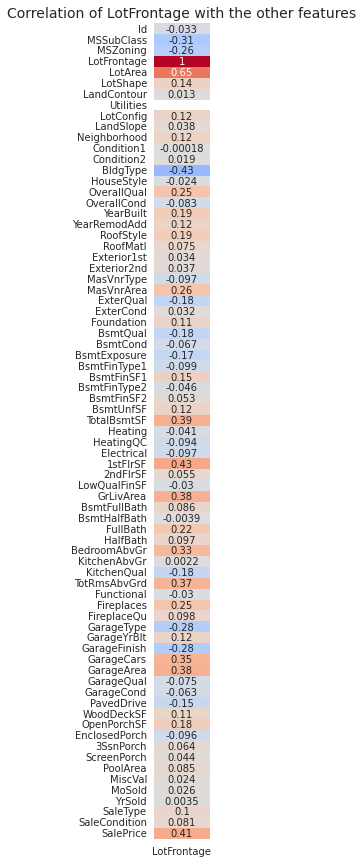

In [29]:
plt.figure(figsize=(1, 15))
sns.heatmap(data=plot_df.corr(method='spearman').loc[:,['LotFrontage']],
            vmin=-1.0, vmax=1.0, cmap='coolwarm', annot=True, cbar=False)
plt.title('Correlation of LotFrontage with the other features', fontsize=14)
plt.show()

In [30]:
lotfrontage_corr = plot_df.corr(method='spearman').loc[:,['LotFrontage']].drop('LotFrontage', axis=0)
lotfrontage_corr[lotfrontage_corr.LotFrontage > 0.5]

,LotFrontage
LotArea,0.649633


We've identified the __LotArea__ feature, which exhibits a correlation of __0.65__ with __LotFrontage__. To understand the relationship better, we'll create a scatterplot to help us determine the function we can employ for estimation.

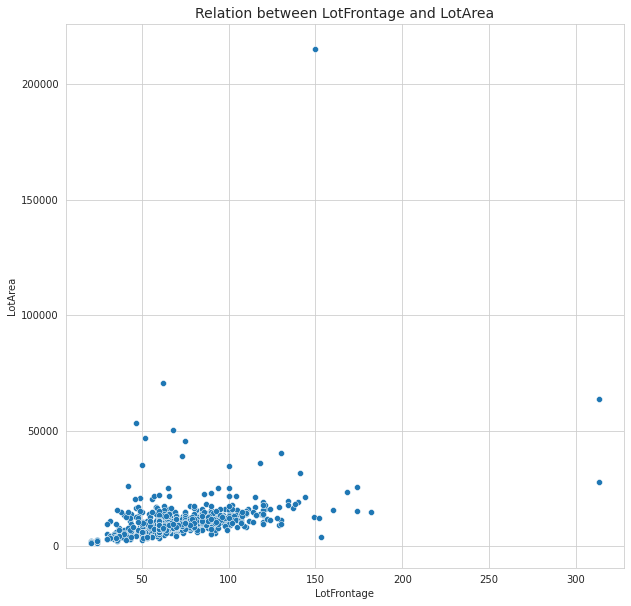

In [31]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=plot_df, x='LotFrontage', y='LotArea')
plt.title('Relation between LotFrontage and LotArea', fontsize=14)
plt.show()

In the scatterplot, we can observe __three significant outliers__ on the upper right side, as well as some apparent __noise__ around the __50000 level__ of __LotArea__. Despite these variations, a __linear relationship__ seems to be present. In the upcoming section, we will delve into fitting a __linear regression model__ to predict the __missing LotFrontage values using LotArea__.

Moving forward, let's explore if we can identify a similar relationship between __GarageYrBlt__ and another feature.

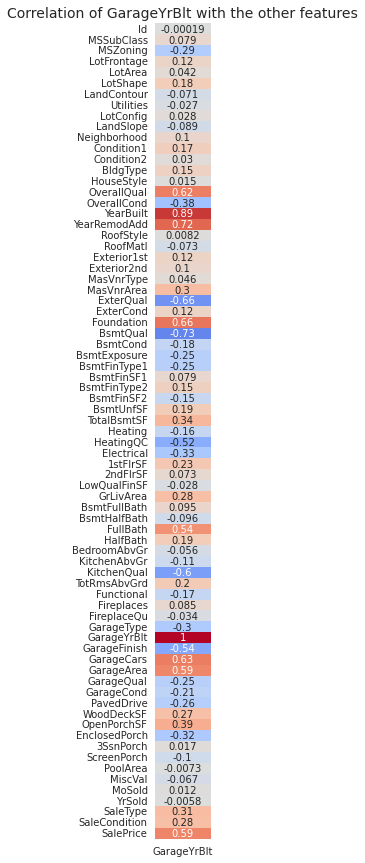

In [32]:
plt.figure(figsize=(1, 15))
sns.heatmap(data=plot_df.corr(method='spearman').loc[:,['GarageYrBlt']],
            vmin=-1.0, vmax=1.0, cmap='coolwarm', annot=True, cbar=False)
plt.title('Correlation of GarageYrBlt with the other features', fontsize=14)
plt.show()

In [33]:
GarageYrBlt_corr = plot_df.corr(method='spearman').loc[:,['GarageYrBlt']].drop('GarageYrBlt', axis=0)
GarageYrBlt_corr[GarageYrBlt_corr.GarageYrBlt > 0.5].sort_values('GarageYrBlt', ascending=False)

,GarageYrBlt
YearBuilt,0.890546
YearRemodAdd,0.722377
Foundation,0.658092
GarageCars,0.630966
OverallQual,0.618193
SalePrice,0.593788
GarageArea,0.591889
FullBath,0.538796


We've found __8__ features that show a strong correlation (__above 0.5__) with __GarageYrBlt__. Among them, we'll choose the one with the __highest correlation__, which is __YearBuilt__. To understand this relationship better, we'll create a scatterplot to figure out the function we can use for estimation.

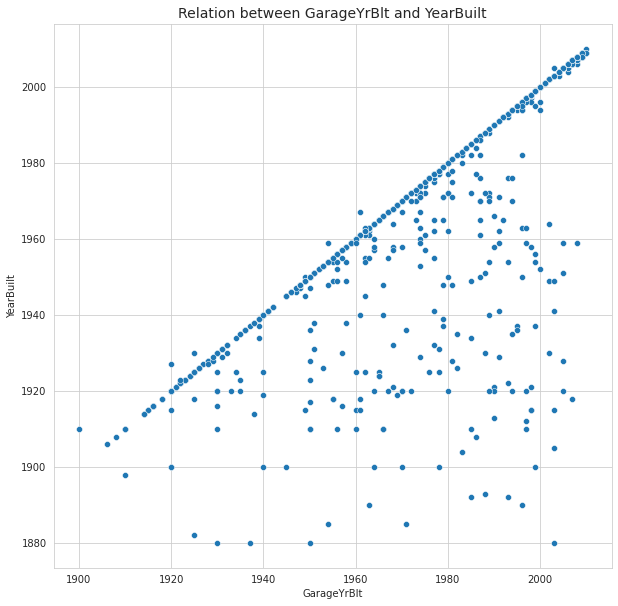

In [34]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=plot_df, x='GarageYrBlt', y='YearBuilt')
plt.title('Relation between GarageYrBlt and YearBuilt', fontsize=14)
plt.show()

It appears that the year a house was built (__YearBuilt__) is closely linked to the year the garage was constructed (__GarageYrBlt__). This connection makes sense since many individuals tend to build a garage along with their house. Now, let's verify if __YearBuilt__ is also among the features selected by __Spearman__ correlation.

In [35]:
'YearBuilt' in spearman_features

True

Given the strong correlation between __YearBuilt__ and __GarageYrBlt__, it's worth considering whether we should remove one of these columns. To make this decision, we can assess the correlation of both __YearBuilt__ and __GarageYrBlt__ with __SalePrice__. The column with the lower correlation could be a candidate for removal.

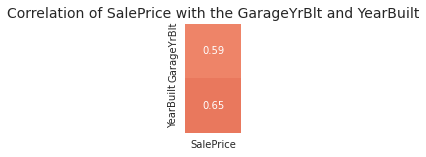

In [36]:
plt.figure(figsize=(1, 2))
sns.heatmap(data=plot_df.corr(method='spearman').loc[['GarageYrBlt', 'YearBuilt'],['SalePrice']],
            vmin=-1.0, vmax=1.0, cmap='coolwarm', annot=True, cbar=False)
plt.title('Correlation of SalePrice with the GarageYrBlt and YearBuilt', fontsize=14)
plt.show()

The correlation between __YearBuilt and SalePrice__ is __more robust__ compared to the correlation between __GarageYrBlt and SalePrice__. Consequently, in the upcoming section, we will proceed with the __removal of the GarageYrBlt__ column.

__Let's recap our progress up to this point:__

* We established a __categories__ dictionary for mapping false categorical feature values to the accurate values outlined in the description file.
* From the __categories__ dictionary, we derived a __cat2num__ dictionary to convert categorical features into numerical equivalents.
* We successfully managed __NaN__ values in categorical columns by utilizing the most frequent value in each column._
* Identified and dropped the __Street__ and __CentralAir__ columns due to their limited information content.
* Compared the __Pearson__ and __Spearman__ correlations between features and the __SalePrice__ column.
* Discovered a __linear correlation__ for imputing NaN values in __LotFrontage__ using __LotArea__.
* Recognized a direct __1-to-1 relationship__ between __GarageYrBlt__ and __YearBuilt__. For addressing NaN values in __GarageYrBlt__, we decided to drop this feature entirely.

While we may have combined some exploratory data analysis with feature engineering, the primary phase of feature engineering will be covered in the subsequent section.

# Feature Engineering and Pipeline

## Engineering of remaining features

To address the NaN values and leverage the strong correlation between __GarageYrBlt__ and __YearBuilt__, we will begin by dropping the __GarageYrBlt__ feature.

In [37]:
plot_df.drop('GarageYrBlt', axis=1, inplace=True)
# we have to remove it from the spearman feature list too
spearman_features.remove('GarageYrBlt')

Next step is building a linear regression model to fill the NaN values in __LotFrontage__ by using __LotArea__.

In [38]:
# remove the 3 extreme outliers
reg_train = plot_df[['LotFrontage', 'LotArea']].copy()
# drop nan
print(f"Original: ", reg_train.shape[0])
reg_train.dropna(axis=0, inplace=True)
print(f"Removed the NaN values: ", reg_train.shape[0])
reg_train = reg_train[(reg_train.LotFrontage < 300) & (reg_train.LotArea < 200000)]
print(f"Removed the 3 outliers: ", reg_train.shape[0])

Original:  1460
Removed the NaN values:  1201
Removed the 3 outliers:  1198


In [39]:
# bring feature and target into the right shape
X, y = reg_train.LotArea.to_numpy().reshape(-1, 1), reg_train.LotFrontage
# create model and fit it
lin_reg = LassoCV(cv=5, random_state=0, fit_intercept=False).fit(X, y)
y_pred = lin_reg.predict(X)

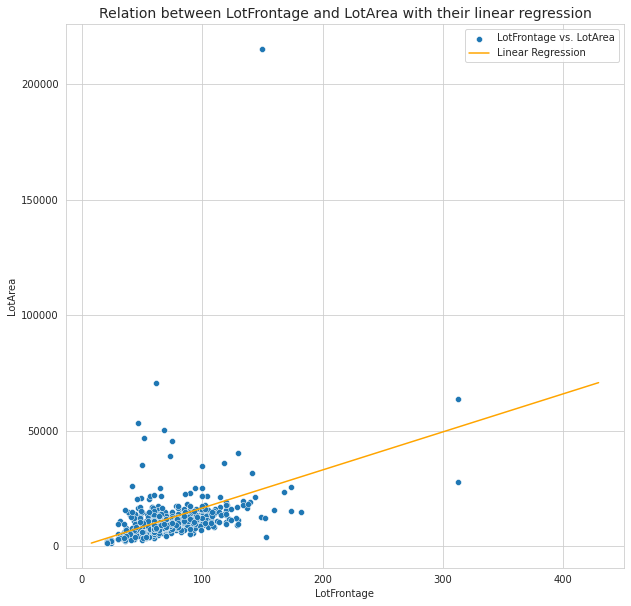

In [40]:
# plotting the relationship
plt.figure(figsize=(10, 10))
ax1 = sns.scatterplot(data=plot_df, x='LotFrontage', y='LotArea')
ax2 = sns.lineplot(x=y_pred, y=X.reshape(-1), color='orange')
plt.title('Relation between LotFrontage and LotArea with their linear regression', fontsize=14)
plt.legend(['LotFrontage vs. LotArea', 'Linear Regression'])
plt.show()

Now with the linear model we can fill the NaN values of the __LotFrontage__ feature.

In [41]:
X_LotArea = plot_df.loc[plot_df.LotFrontage.isnull(), 'LotArea']
plot_df.loc[plot_df.LotFrontage.isnull(), 'LotFrontage'] = lin_reg.predict(X_LotArea.to_numpy().reshape(-1, 1))
plot_df.loc[plot_df.LotFrontage.isnull(), 'LotFrontage'].shape

(0,)

Let's take another look to see if there are any remaining empty values in our features.

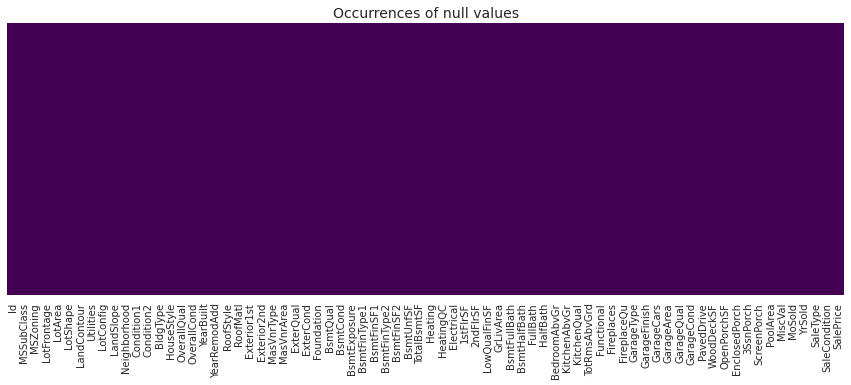

In [42]:
plt.figure(figsize=(15, 5))
sns.heatmap(data=plot_df.isnull(), cmap='viridis', yticklabels=False, xticklabels=True, cbar=False)
plt.title('Occurrences of null values', fontsize=14)
plt.show()

No empty values are apparent. We can now move forward to building the Feeding Pipeline.

## Pipeline construction

To ensure consistency in our machine learning model's data preprocessing, we can employ the __Pipeline__ and __ColumnTransformer__ classes provided by the Sklearn library. This allows us to streamline the preprocessing steps and maintain uniformity across different runs of our model.

In [43]:
# split data into train and test set
plot_df.dropna(axis=0, inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(plot_df[list(spearman_features)],
                                                      plot_df.SalePrice, test_size=0.2, 
                                                      random_state=23)
numerical_cols = list(set(numerical_cols) & set(spearman_features)) 

categorical_cols = list(set(categorical_cols) & set(spearman_features))

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('MinMaxScaler', MinMaxScaler(feature_range=(0,1)))
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='error'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('MinMaxScaler',
                                                  MinMaxScaler())]),
                                 ['YearBuilt', 'GarageArea', 'TotalBsmtSF',
                                  'GrLivArea', 'GarageCars', 'TotRmsAbvGrd',
                                  'YearRemodAdd', 'OverallQual', 'LotArea',
                                  'MasVnrArea', 'BsmtFinSF1', 'Fireplaces',
                                  'HalfBath', 'OpenPorchSF', 'WoodDeckSF',
                                  '1stFlrSF', 'FullBath', 'LotFrontage']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['MSZoning', 'HeatingQC', 'GarageType',
                        

# Model construction and evaluation

## XGBRegressor vs. SVR

Let's figure out which model works better for our regression task. This will help us choose the right model for predicting the target variable.

In [44]:
# model selection
models = [
    SVR(),
    xgb.XGBRegressor(n_estimators=700)
]

# fit the models via the preprocessor as pipeline
r2_scores = {}
for model in models:
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('Regression', model)
    ])
    
    # Fit the model with train data
    pipeline.fit(X_train, y_train)
    
    # Predict the model with test data
    y_pred = pipeline.predict(X_valid)
    
    r2_scores[str(model.__class__).split('.')[-1]] = metrics.r2_score(y_valid, y_pred)
    print('Model Name: ', model)
    print('R2_score:', round(metrics.r2_score(y_valid, y_pred),6))
    print('MSE:', round(metrics.mean_squared_error(y_valid, y_pred),6))

Model Name:  SVR()
R2_score: -0.027588
MSE: 5181073414.412658
Model Name:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
R2_score: 0.89915
MSE: 508481374.200794


It appears that the __XGBRegressor__ model is __more suitable__ for this regression task compared to a __Support Vector Machine__. Now, let's explore whether a __Dense Neural Network__ can surpass the performance of the __XGBRegressor__.

## Dense Neural Network

Let's create, set up, and train a Dense Neural Network to see how it performs compared to the XGBRegressor model.

In [45]:
# preprocess the data with our preprocessor and build the neural net
tf_X = preprocessor.fit_transform(X_train)
tf_X_val = preprocessor.transform(X_valid)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(tf_X.shape[1],)),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 69)               276       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               17920     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 59,413
Trainable params: 59,275
Non-trainable params: 138
__________________________________________________

2023-08-21 13:42:26.850490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-21 13:42:26.855945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-21 13:42:26.856369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-21 13:42:26.857139: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [46]:
# compile the network and fit it
model.compile(optimizer='adam', loss='mse')

history = model.fit(tf_X, y_train, 
                    epochs=149, verbose=0, 
                    validation_data=(tf_X_val, y_valid))

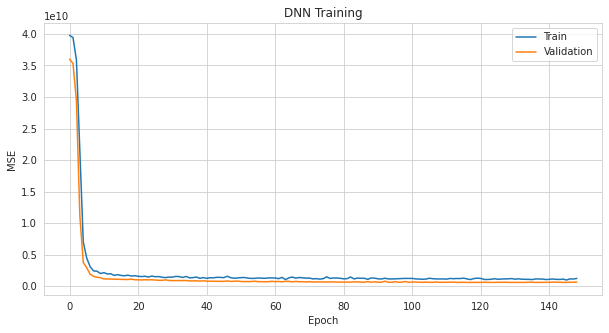

In [47]:
# Plot training and validation loss values
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DNN Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [48]:
# let's check the R2-Score of the network and XGBRegressor
print(f"Network R2-Score: {metrics.r2_score(y_valid, model.predict(tf_X_val))}")
xgb_score = r2_scores["XGBRegressor'>"]
print(f"XGBRegressor R2-Score: {xgb_score}")

Network R2-Score: 0.871129261470987
XGBRegressor R2-Score: 0.8991503281817457


__The XGBRegressor model does a better job on this dataset in terms of both MSE and R2-Score when compared to the neural network.__

## Finetuning the best XGB model

Let's explore the possibility of further enhancing the performance of the __XGBRegressor__ model by utilizing __GridSearchCV__. This approach involves systematically tuning __hyperparameters__ to achieve improved results.

In [49]:
# last XGBRegressor model with GridSearchCV for comparison
parameters = {'n_estimators': [700]}
X = preprocessor.fit_transform(plot_df[list(spearman_features)])
y = plot_df.SalePrice
reg = GridSearchCV(xgb.XGBRegressor(), parameters, cv=3)
reg.fit(X, y)
reg.best_score_

0.8574478633789955

In [50]:
# main GridSearchCV for hyperparameter tuning
parameters = {'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]}
X = preprocessor.fit_transform(plot_df[list(spearman_features)])
y = plot_df.SalePrice
reg = GridSearchCV(xgb.XGBRegressor(), parameters, cv=3)
reg.fit(X, y)
reg

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [51]:
reg.best_params_

{'max_depth': 2, 'n_estimators': 200}

In [52]:
reg.best_score_

0.8728375620950651

The score you see above might look worse than what we had with our previous __XGBRegressor__ in the __Pipeline__. But don't be fooled by this difference. This result comes from using GridSearch __CV__, which involves __cross-validation__ and makes the model more resistant to overfitting on the training data. You can notice this when comparing the first and last GridSearch __CV__ outcomes.

# Packing together and make submission

We need to make a function for preparing the dataframe, just like we did in __chapter 2 and 3__. Then, we'll apply this function to our data and use our regressor model to make predictions. Let's start by creating a checklist.

* Drop columns with poor information: __Alley__, __PoolQC__, __Fence__, __MiscFeature__, __Street__, __CentralAir__ and __GarageYrBlt__
* Replace the categorical values with the true description values
* Apply function convert_cat2num
* Filter DataFrame by using the __spearman_features__ list
* Apply fillna with most frequent value on __MasVnrArea__ column
* Apply linear regression model to fillna of __LotFrontage__ with __LotArea__ as feature
* Transform the features with the __preprocessor__
* Predict __SalePrice__ by using the best __XGBRegressor__ model from the __GridSearchCV__
* Create __submission file__

In [53]:
def preprocess_dataframe(df):
    df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Street', 'CentralAir', 'GarageYrBlt'], 
            axis=1, inplace=True)
    
    # correct column MSZoning typos
    df.MSZoning = df.MSZoning.str.replace('C (all)', 'C', regex=False)

    # correct column Neighborhood typos
    df.Neighborhood = df.Neighborhood.str.replace('NAmes', 'Names')

    # correct column BldgType typos
    df.BldgType = df.BldgType.str.replace('2fmCon', '2FmCon')
    df.BldgType = df.BldgType.str.replace('Duplex', 'Duplx')
    df.BldgType = df.BldgType.str.replace('Twnhs', 'TwnhsI')
    df.BldgType = df.BldgType.str.replace('TwnhsIE', 'TwnhsE')

    # correct column Exterior2nd typos
    df.Exterior2nd = df.Exterior2nd.str.replace('Brk Cmn', 'BrkComm')
    df.Exterior2nd = df.Exterior2nd.str.replace('CmentBd', 'CemntBd')
    df.Exterior2nd = df.Exterior2nd.str.replace('Wd Shng', 'WdShing')
    
    convert_cat2num(df)
    feature_df = df[spearman_features].copy()
    feature_df.MasVnrArea.fillna(feature_df.MasVnrArea.value_counts().index[0], inplace=True)
    X_reg = feature_df.loc[feature_df.LotFrontage.isnull(), 'LotArea'].to_numpy().reshape(-1, 1)
    feature_df.loc[feature_df.LotFrontage.isnull(), 'LotFrontage'] = lin_reg.predict(X_reg)
    X = preprocessor.transform(feature_df)
    return X

In [54]:
submission = reg.best_estimator_.predict(preprocess_dataframe(test_df))

In [55]:
# Create a DataFrame with 'Id' and 'SalePrice' columns
output = pd.DataFrame({'Id': test_df.Id,
                       'SalePrice': submission.round(2)}) 
# Save the predictions to a CSV file
output.to_csv('submission.csv', index=False)

Managed to achieve a Kaggle public score of __0.14898__, placing us in the __middle of the rankings__. Thanks for following along! If you have more questions or sugestions for improvement, feel free to comment.